[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Besides **overfitting**, there is also another issue that can arise when training models for image classification: **overconfidence**.  **Label smoothing** is a regularization technique that addresses both problems. Essentially, label smoothing relaxes the confidence on the labels. For instance, label 1 can be replaced by 0.9 and label 0 by 0.1. These are soft labels, instead of hard labels, that is 0 and 1.

Therefore, in case there are mislabelled images, label smoothing will help to reduce a too high loss and, consequently, improve the model's robustness and performance.

In this notebook, this technique is evaluated by comparing different levels of smoothing and checking their consequences in the model's performance.

#### Importing libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from numpy import expand_dims

AUTOTUNE = tf.data.AUTOTUNE

#### Auxiliar functions

In [2]:
class EnoughPerformanceReached(Callback):
    """
    Callback for stopping training when the performance is greater than <threshold>.
    """

    def __init__(self, threshold):
        self.monitor = "val_categorical_accuracy"
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy >= self.threshold:
            print(f"[INFO] Enough performance reached: {current_accuracy}")
            self.model.stop_training = True


# Function for plotting images.
def plot_samples(sample_images):
    
    PLOT_NUM_ROWS = 3
    PLOT_NUM_COLS = 3
    plt.figure(figsize=(PLOT_NUM_ROWS*1.5, PLOT_NUM_COLS*1.5), dpi=100)
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(PLOT_NUM_ROWS, PLOT_NUM_COLS, ix+1)
        plt.imshow(sample_image.numpy())
        plt.axis("off")
    plt.show()


def read_data(path_list, im_size=224):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-2]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-3]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, (im_size, im_size), interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print(e)
                #print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y, idx2tag


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience, lr_factor):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.
            lr_factor: Factor for reducing the learning rate when performance
                       is not improving.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_categorical_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_categorical_accuracy", mode="max", patience=patience, verbose=1
        ),
        EnoughPerformanceReached(0.99),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs set with 'patience' var.
        ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            factor=lr_factor,
            min_lr=1e-6,
            patience=patience // 2,
            verbose=1,
        ),
    ]

#### Architecture definition

In [16]:
def get_model(label_smoothing):
    base_model = keras.applications.ResNet50V2(include_top=False,
                                               weights="imagenet",
                                               input_shape=(IM_SIZE, IM_SIZE, 3))
    base_model.trainable = True

    inp = layers.Input(shape=(IM_SIZE, IM_SIZE, 3))
    x = layers.Lambda(applications.resnet_v2.preprocess_input)
    x = base_model(inp, training=True)
    x = layers.Conv2D(32, (1, 1), activation="relu")(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(HIDDEN_UNITS, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inp, outputs=out)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False,
                                                            label_smoothing=label_smoothing),
                  metrics=[keras.metrics.CategoricalAccuracy(name="acc")])
    
    return model

#### Experimental constants

In [24]:
IM_SIZE = 224
NUM_CLASSES = 3
NUM_EPOCHS = 5
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-4
RANDOM_STATE = 2021
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.2
WEIGHTS_FILE_NAME = "weights.h5"  # File that stores updated weights
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
BASE_PATH = "eden_library_datasets" + os.path.sep

# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Pepper-Capsicum_annuum-Healthy-PRX-RGB-NA-20200812-20210225103251/images",
    BASE_PATH + "Tomato-Solanum_lycopersicum-Healthy-PRX-RGB-NA-20200904-20210225103509/images",
    BASE_PATH + "Watermelon-Citrullus_lanatus-Healthy-PRX-RGB-NA-20200724-20210225104150/images"
]

#### Loading data

In [25]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path))
    i += 1
x, y, idx2tag = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 94/94 [00:03<00:00, 31.09it/s]


#### Splitting data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VAL_SPLIT, 
                                                  shuffle = True,
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

#### Creating datasets

In [28]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = (
    train_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_ds = (
    validation_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

#### Displaying some random samples

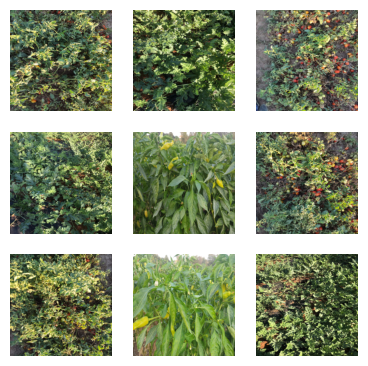

In [29]:
sample_images, sample_labels = next(iter(train_ds))
plot_samples(sample_images)

#### Training model with default Label Smoothing = 0.0

In [30]:
model = get_model(label_smoothing=0.0)
model.save_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100, 2)}%")

Epoch 1/5
32/32 [==============================] - 8s 112ms/step - loss: 0.3497 - acc: 0.9006 - val_loss: 0.0382 - val_acc: 0.9775
Epoch 2/5
32/32 [==============================] - 2s 54ms/step - loss: 0.2077 - acc: 0.9245 - val_loss: 0.0440 - val_acc: 0.9888
Epoch 3/5
32/32 [==============================] - 2s 56ms/step - loss: 0.0475 - acc: 0.9920 - val_loss: 0.0465 - val_acc: 0.9775
Epoch 4/5
32/32 [==============================] - 2s 55ms/step - loss: 0.0324 - acc: 0.9881 - val_loss: 0.0796 - val_acc: 0.9888
Epoch 5/5
32/32 [==============================] - 2s 55ms/step - loss: 0.1579 - acc: 0.9781 - val_loss: 0.0524 - val_acc: 0.9775
Clean Test Accuracy: 98.1%


#### Training model with Label Smoothing = 0.1

In [31]:
model = get_model(label_smoothing=0.1)
model.load_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

Epoch 1/5
32/32 [==============================] - 8s 93ms/step - loss: 0.7033 - acc: 0.8569 - val_loss: 0.3863 - val_acc: 0.9775
Epoch 2/5
32/32 [==============================] - 2s 56ms/step - loss: 0.3837 - acc: 0.9781 - val_loss: 0.3370 - val_acc: 0.9888
Epoch 3/5
32/32 [==============================] - 2s 55ms/step - loss: 0.3196 - acc: 1.0000 - val_loss: 0.3401 - val_acc: 0.9775
Epoch 4/5
32/32 [==============================] - 2s 56ms/step - loss: 0.3111 - acc: 1.0000 - val_loss: 0.3299 - val_acc: 0.9888
Epoch 5/5
32/32 [==============================] - 2s 56ms/step - loss: 0.3050 - acc: 1.0000 - val_loss: 0.3311 - val_acc: 0.9888
Clean Test Accuracy: 100.0%


#### Training model with Label Smoothing = 0.01

In [32]:
model = get_model(label_smoothing=0.01)
model.load_weights("initial_weights.h5")

history = model.fit(train_ds,
                    validation_data=validation_ds, 
                    epochs=NUM_EPOCHS)

_, test_acc = model.evaluate(test_ds, 
                             verbose=0)
print(f"Clean Test Accuracy: {round(test_acc*100,2)}%")

Epoch 1/5
32/32 [==============================] - 7s 89ms/step - loss: 0.4773 - acc: 0.8708 - val_loss: 0.1318 - val_acc: 0.9888
Epoch 2/5
32/32 [==============================] - 2s 55ms/step - loss: 0.2026 - acc: 0.9523 - val_loss: 0.2030 - val_acc: 0.9663
Epoch 3/5
32/32 [==============================] - 2s 56ms/step - loss: 0.1204 - acc: 0.9841 - val_loss: 0.0868 - val_acc: 0.9775
Epoch 4/5
32/32 [==============================] - 2s 56ms/step - loss: 0.0931 - acc: 0.9881 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 5/5
32/32 [==============================] - 2s 57ms/step - loss: 0.0627 - acc: 1.0000 - val_loss: 0.0887 - val_acc: 0.9775
Clean Test Accuracy: 100.0%


## Conclusions
The correct selection of the label smoothing configuration makes a difference in test performance.

## Possible Extensions
1. Use a different pre-trained network (for instance, MobileNetV3Large).
2. Try different values for label smoothing.
3. Try a different training approach where pre-trained weights are not loaded.
4. Try different epochs and batch sizes.

## Bibliography

Müller, R., Kornblith, S., & Hinton, G.E. (2019). (When Does Label Smoothing Help? NeurIPS. https://arxiv.org/pdf/1906.02629v1.pdf)

https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06

https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

https://medium.com/@nainaakash012/when-does-label-smoothing-help-89654ec75326